<h1 align="center"><font size="6"> Les méthodes de descente de gradient </font> (deuxième partie)</h1>
<hr> 

<h1>Table des matières</h1>

<div class="alert alert-block alert-info" style="margin-top : 20px">
      <ul>
          <li><a href="#prelim">Préliminaires</a></li>
          <li><a href="#Newton">La méthode de Newton</a></li>
          <li><a href="#BFGS">Une méthode de quasi-Newton (BFGS)</a></li>
      </ul>
</div>
<br>
<h>

<a id='prelim'></a>
<h2>Préliminaires</h2>
<hr>

On commence par importer les bibliothèques neecéssaires (_numpy_ et _matplotlib.pyplot_).

On définit aussi deux functions pour la visualisation de: *1/* les lignes de niveaux de la fonction ojectif et *2/* le champ de gradients (pour les fonctions objectifs dépendant de deux variables). 

Il y a aussi un exemple de graphique pour observer la vitesse de convergence des méthodes d'optimisation.

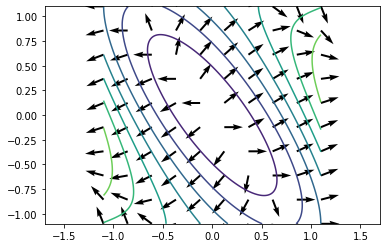

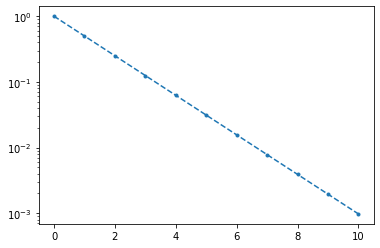

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

def draw_vector_field(F, xmin, xmax, ymin, ymax, N=15):
    X = np.linspace(xmin, xmax, N)  # x coordinates of the grid points
    Y = np.linspace(ymin, ymax, N)  # y coordinates of the grid points
    U, V = F(*np.meshgrid(X, Y))  # vector field
    M = np.hypot(U, V)  # compute the norm of (U,V)
    M[M == 0] = 1  # avoid division by 0
    U /= M  # normalize the u componant
    V /= M  # normalize the v componant
    return plt.quiver(X, Y, U, V, angles='xy')

def level_lines(f, xmin, xmax, ymin, ymax, levels, N=500):
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    z = f(*np.meshgrid(x, y))
    level_l = plt.contour(x, y, z, levels=levels)
    #plt.clabel(level_l, levels, fmt='%.1f') 

f = lambda x, y : np.cosh(x)+ np.sin(x + y)**2
df = lambda x, y : np.array([np.sinh(x) + 2*np.cos(x + y)*np.sin(x + y),
                             2*np.cos(x + y)*np.sin(x + y)])
%matplotlib inline
level_lines(f, -1.1, 1.1, -1.1, 1.1, np.linspace(1, 3, 10))
draw_vector_field(df, -1.1, 1.1, -1.1, 1.1, 10)
plt.axis('equal')
plt.show()

# Représentation graphique des valeurs de f au cours des itérations.
N = 10
F = 2**(-np.linspace(0,N,N+1))
plt.figure()
plt.semilogy(range(N + 1), F, '.', linestyle='dashed')
plt.show()

<a id='Newton'></a>
<h2>La méthode de Newton</h2>
<hr>

On suppose dans ce TP que $f:\mathbb{R}^N\to\mathbb{R}$ est de classe $C^2$ au moins.

La méthode de Newton (ou de Newton-Raphson) est une méthode de descente itérative dans laquelle la direction de descente à l'étape $k$ est choisie de manière à minimiser le développement limité au second ordre de $f$ au point $x^k$, c'est-à-dire
$$
\tag{4}
m_k(d):=f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T D^2 f(x^k) d.
$$
Si la matrice (symétrique) $D^2 f(x^k)$ est définie  positive le minimiseur de $m^k$ existe et est unique. On note $H^k$ l'inverse de $D^2 f(x^k)$, $g^k:=\nabla f(x^k)$ et $d^k$ le minimiseur de (4).

***Question 15.*** Exprimez $d^k$ en fonction de $H^k$ et $g^k$.

> On a $m_k(d):=f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T D^2 f(x^k) d$
>
> Soit $\nabla m_k(d) = \nabla f(x^k) + D^2 f(x^k) d$
>
> Alors  $\nabla m_k(d)=0$ implique que : 
>
> $d^k=-(D^2 f(x^k))^{-1} \cdot \nabla f(x^k)$ 
>
>  **$d^k=-H^kg^k$** 
> (par définition de $H^k$, $g^k$)

Soit $\Lambda>0$. On pose $f_\Lambda(x,y):=(1-x)^2 + \Lambda\,(y-x^2)^2$, pour $(x,y)\in\mathbb{R}^2$.  

__Question 16.__ Calculez $\nabla f_\Lambda(x,y)$. Trouves le(s) minimiseur(s) de $f_\Lambda$. Tracez quelques lignes de niveau de $f_\Lambda$ ainsi que le champ vectoriel renormalisé $(1/|\nabla f_\Lambda|)\nabla f_\Lambda$ pour $\Lambda=100$. Calculez $D^2 f(x,y)$ et son inverse $H_\Lambda(x,y)$.

#####  Calcul de $\nabla f_\Lambda(x,y)$
$\nabla f_\Lambda(x,y) = (2-2x+\Lambda(-4xy+4x^3) , 2\Lambda \cdot (y- x^2))$

##### Trouver les minimiseurs de $f_\Lambda$ 
> On pose $\nabla f_\Lambda(x,y)=(0,0)$ alors : 
>
> $
> \begin{aligned}
> &\begin{cases}
> 2-2x+\Lambda(-4xy+4x^3) = 0 \\
> 2 \Lambda y - 2 \Lambda x^2  =0
> \end{cases}\\
> \end{aligned}
> $
>
>
>$
>\Rightarrow
>\begin{aligned}
>&\begin{cases}
>2x=2 \\
>y=x^2 
>\end{cases}\\
>\end{aligned}
>$
>
>
>$
>\Rightarrow
>\begin{aligned}
>&\begin{cases}
>x=1 \\
>y=1 
>\end{cases}\\
>\end{aligned}
>$
>
> **Le minimiseur de $f_\Lambda$ est (1,1)**

##### Calcul de $D^2 f(x,y)$ et son inverse $H_\Lambda(x,y)$.

$D^2 f(x,y) =$
$
\begin{pmatrix}
    2-4\Lambda y+12x^2\Lambda &,& -4\Lambda  x \\
    -4\Lambda x &,& 2\Lambda \\
\end{pmatrix}
$

> Soit det le determinant de cette matrice :
>
> $det=2\Lambda(2-4\Lambda y+12 \Lambda x^2) + 4 \Lambda x (-4\Lambda x)$
>
> $det=4\Lambda -8\Lambda^2y+24\Lambda^2x^2-16\Lambda^2x^2 $
>
> d'où : **$det= 4\Lambda(1-2\Lambda y + 2 \Lambda x^2)$**


>Pour **$det\neq0$** , c'est à dire $y\neq \dfrac1{2\Lambda}+ x^2  $ , on a:

$H_\Lambda(x,y) = \dfrac1{det}\cdot$
$
\begin{pmatrix}
    2\Lambda &,& 4\Lambda  x \\
    4\Lambda x &,& 2-4\Lambda y+12x^2\Lambda\\
\end{pmatrix}
$
$=$
$
\begin{pmatrix}
    \dfrac1{2(1-2\Lambda(y-x^2))} &,& \dfrac{x}{1-2\Lambda(y-x^2)}  \\
    \dfrac{x}{1-2\Lambda(y-x^2)} &,& \dfrac{1-2\Lambda y+6x^2\Lambda}{2\Lambda(1-2\Lambda(y-x^2))}\\
\end{pmatrix}
$



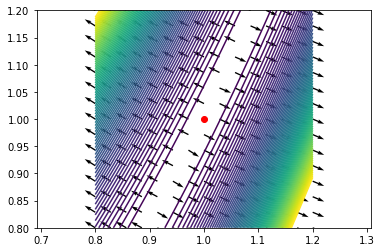

In [32]:
## Solution 
Lambda = 100
f = lambda x,y : (x-1)**2 + Lambda*(y - x**2)**2
df = lambda x,y : np.array([-2*(1- x) - 4*Lambda*x*(y-x**2), 2*Lambda*(y - x**2)])
ddf = lambda x,y : np.array([[2 - 4*Lambda*y + 12*Lambda*x**2 , -4*Lambda*x], [-4*Lambda*x, 2*Lambda]])
det = lambda x,y : 4*Lambda - 8*(Lambda**2)*y + 8*(Lambda**2)*x**2
HH = lambda x,y : (1/det)*np.array([[2*Lambda, 4*Lambda*x],[4*Lambda*x, 2 - 4*Lambda*y + 12*Lambda*x**2 ]])

level_lines(f, .8, 1.2, 0.8, 1.2, np.linspace(0, 30, 80))
draw_vector_field(df, .8, 1.2, 0.8, 1.2, 15)
plt.plot(1,1,'or')
plt.axis('equal')
plt.show();

__Question 17.__ Implémentez la méthode de Newton et appliquez-la à la fonction ci-dessus avec $c=0.1$, $\beta=0.75$ et $x^0=(0,0)$. Représentez les itérations sur un graphique et tracez $\ \log(f_\Lambda(x^k))\ $ en fonction de $k$. Commentez les résultats.

_Indication:_ Testez d'abord l'algorithme sur la fonction quadratique ci-dessous.

In [33]:
Lambda = 1000
f = lambda x,y : (x-1)**2 + Lambda*(y - x**2)**2
df = lambda x,y : np.array([-2*(1- x) - 4*Lambda*x*(y-x**2), 2*Lambda*(y - x**2)])
ddf = lambda x,y : np.array([[2 - 4*Lambda*y + 12*Lambda*x**2 , -4*Lambda*x], [-4*Lambda*x, 2*Lambda]])
det = lambda x,y : 4*Lambda - 8*(Lambda**2)*y + 8*(Lambda**2)*x**2
HH = lambda x,y : (1/det)*np.array([[2*Lambda, 4*Lambda*x],[4*Lambda*x, 2 - 4*Lambda*y + 12*Lambda*x**2 ]])


In [34]:
## Parameters
c, beta = .1, .75
epsilon = 1e-8
itermax = 200
iter_ls_max = 40

x0 = np.array([0., 0.])


minimum de f= 1.0496632015426794e-18  atteint en x =  [1. 1.]  et avec un nombre d'itérations = 24


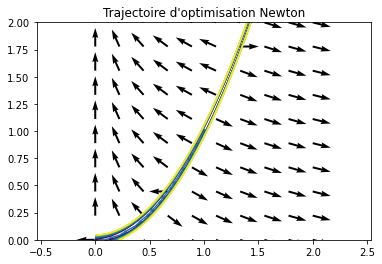

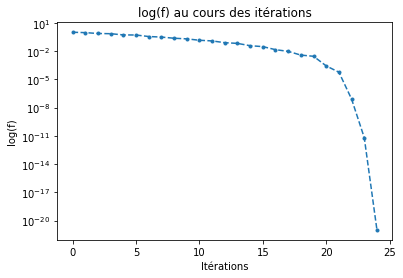

In [35]:
def newton_method(f, df, ddf, x0, c, beta, epsilon, itermax):
    x = x0
    x_list = [x]
    f_values = [f(x[0], x[1])]
    i = 0

    while i < itermax and np.linalg.norm(df(x[0], x[1])) > epsilon:
        H_inv = np.linalg.inv(ddf(x[0], x[1]))
        d = -np.dot(H_inv, df(x[0], x[1]))
        alpha = 1

        # Recherche linéaire
        while f(x[0] + alpha*d[0], x[1] + alpha*d[1]) > f(x[0], x[1]) + c * alpha * np.dot(df(x[0], x[1]), d):
            alpha *= beta

        x = x + alpha * d
        x_list.append(x)
        f_values.append(f(x[0], x[1]))
        i += 1

    return x_list, f_values, i




# Application de la méthode de Newton
x_list_newton, f_values_newton, iteration = newton_method(f, df, ddf, x0, c, beta, epsilon, itermax)

print('minimum de f=',f(x_list_newton[-1][0],x_list_newton[-1][0]),' atteint en x = ',x_list_newton[-1],' et avec un nombre d\'itérations =', iteration)

# plot the results 
plt.figure()
plt.plot([x[0] for x in x_list_newton], [x[1] for x in x_list_newton], '.', linestyle='-')
level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
draw_vector_field(df, 0, 2, 0, 2, 10)
plt.axis('equal')
plt.title("Trajectoire d'optimisation Newton")
plt.show()

# Représentation graphique des valeurs de f au cours des itérations.
plt.figure()
plt.semilogy(range(len(x_list_newton)), [f(x[0],x[1]) for x in x_list_newton], '.', linestyle='dashed')
plt.title('log(f) au cours des itérations')
plt.xlabel('Itérations')
plt.ylabel('log(f)')
plt.show()



### Observations 
> On remarque que la méthode de Newton fonctionne convenablement puis qu'elle converge assez lentement au cours des premières itérations, puis converge très rapidement lors des suivantes. Ce comportement est caractéristique la méthode de Newton. 

<a id='BFGS'></a>
<h2> Une méthode de quasi-Newton (BFGS)</h2>
<hr>

Lorsque le nombre de paramètres est important comme il est habituel en Machine Learning, le calcul des matrices hessiennes $D^2f(x^k)$ et la résolution des systèmes linéaires $D^2f(x^k) d^k=-g^k$ peuvent être trop coûteux. Cependant, il est souvent encore possible d'obtenir une convergence superlinéaire en remplaçant $[D^2f(x^k)]^{-1}$ par une approximation moins gourmande à calculer qu'on notera $H^k$. Il existe plusieurs algorithmes basés sur cette idée. Nous présentons l'une des plus populaires : la méthode BFGS du nom de leurs découvreurs (Broyden, Fletcher, Goldfarb et Shanno).

__Description de la méthode__ : Supposons qu'à l'étape $k$ nous ayons une approximation définie positive symétrique $H^k$ de $\left[D^2f(x^k)\right]^{-1}$. On note $B^k$ son inverse (qui est une approximation de $D^2f(x^k)$). Comme ci-dessus, nous définissons notre direction de descente $d^k$ comme le minimiseur de
$$
f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T B^k d.
$$
Cela conduit à la formule :
$$
d^k = -\left[B^k\right]^{-1} \nabla f(x^k) = - H^k g^k. 
$$

On cherche ensuite $\alpha_k$ satisfaisant (5) par la méthode de ``backtracking", toujours avec $\alpha=1$ et on pose
$$
x^{k+1} := x^k +\alpha_k d^k.
$$

Maintenant, nous avons besoin de calculer approximation $H^{k+1}$ de $\left[D^2f(x^{k+1})\right]^{-1}$. Pour cela, rappelons que nous voulons
$$
\tilde m_{k+1} (d):= f(x^{k+1}) + g^{k+1}\cdot d +\dfrac 12 d^T B^{k+1} d,
$$
soit une approximation de
$$
\overline m_{k+1}(d):= f(x^{k+1} + d).
$$
Nous avons déjà par construction,
$$
\tilde m_{k+1}(0)=\overline m_{k+1}(0)=f(x^{k+1})\qquad\text{et}\qquad \nabla \tilde m_{k +1}(0)=\nabla \overline m_{k+1}(0)=g(x^{k+1}).
$$
Nous appliquons la nouvelle condition
$$
\nabla m_{k+1}(-\tau_k d^k)=\nabla \overline m_{k+1}(-\tau_k d^k)=g^k.
$$

En notant $a^k:=g^{k+1}-g^k$ et $b^k:=\tau^kd^k=x^{k+1}-x^k$, cela équivaut à $B^{k+1}b^k=a^k$. En supposant que $B^{k+1}$ est inversible, cela équivaut à demander que $H^{k+1}$ soit solution de
$$
\tag{6}
Ha^k=b^k.
$$
Une condition nécessaire et suffisante pour que (6) admette une solution symétrique définie positive $H$ est :
$$
\tag{7}
\left<a^k;b^k\right> >0.
$$

Nous ne voulons pas perdre toute l'information déjà contenue dans $H^k$, donc, en supposant que (7) soit vraie, nous choisissons une solution de (6) aussi proche que possible de $H^k$. Un choix populaire consiste à définir :
$$
\tag{8}
H^{k+1} := \left(I-\rho_k b^k\otimes a^k\right) H^k \left(I-\rho_k a^k\otimes b^k\right) + \rho_k b^k\otimes b^k,\quad\text{ avec }\quad \rho_k:=\dfrac1{\left<a^k;b^k\right>}.
$$

__Question 18.__ Vérifiez que la formule (8) donne bien une solution à (6). Vérifiez que $H^{k+1}$ ainsi définie est une matrice symétrique définie positive 

###### Solution de l'équation (6)

> Pour vérifier que $H^{k+1}$ résout $Ha^k = b^k$, nous appliquons $H^{k+1}$ à $a^k$ et utilisons les propriétés des produits tensoriels et de la symétrie de $H^k$. Après manipulation algébrique, on trouve que $H^{k+1}a^k = b^k$, démontrant ainsi que $H^{k+1}$ est une solution valide de l'équation (6).

###### Symétrie et définition positive de $H^{k+1}$

> - **Symétrie :** La symétrie de $H^{k+1}$ découle de sa construction via des produits tensoriels et de la matrice symétrique $H^k$. Les opérations préservent cette symétrie.
>
> - **Définition positive :**
>    - **Non-négativité :** Pour tout vecteur $d \in \mathbb{R}^N$, en définissant $w = d - \rho_k \langle b^k; d \rangle a^k$, on montre que $d^T H^{k+1} d  = w^TH^kw + \rho_k \left<d;b^k\right>^2 \geq 0$.  Ceci est dû au fait que $w^T H^k w$ est non-négatif (car $H^k$ est définie positive) et à la non-négativité du terme $\rho_k \langle d; b^k \rangle^2$.
>
>   - **Strictement positif pour $d \neq 0$  :** On montre que si $d^T H^{k+1} d = 0$, alors $d = 0$. Cela est réalisé en deux étapes : 
>       - $w = 0$ implique $d$ proportionnel à $a^k$, c'est à dire $d=\lambda a^k$ pour un $\lambda\in \mathbb{R}$ .
>       - En utilisant $\langle d; b^k \rangle = 0$ et le fait que $d$ soit proportionnel à $a^k$, on conclut que $d$ doit être nul, car $\langle a^k; b^k \rangle$ est strictement positif selon la condition (7).
>
> Donc, $H^{k+1}$ est  une solution de (6), symétrique et définie positive, préservant les propriétés nécessaires pour la convergence efficace de la méthode BFGS.


__Question 19.__ Implémentez la méthode BFGS et appliquez-la à la fonction ci-dessus avec $c = 0.1$, $\beta=0.75$ et $x^0=(0,0)$. Comme premier approximation de $D^2f(x^0)$ on prendra $H^0=I$.

Représentez les itérations sur un graphique et tracez $\ \log(f(x^k))\ $ en fonction de $k$. Observez et commentez.

Minimum de f =  7.837853117914818e-17  atteint en x =  [1. 1.]  avec un nombre d'itérations = 70


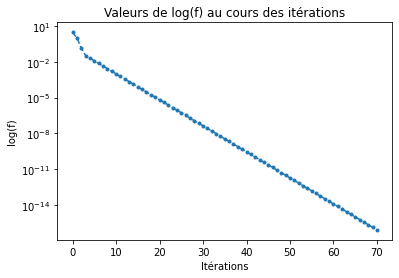

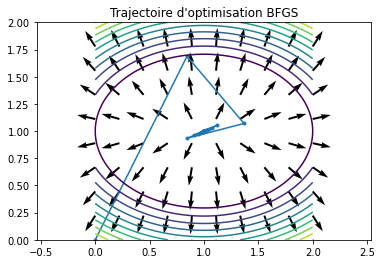

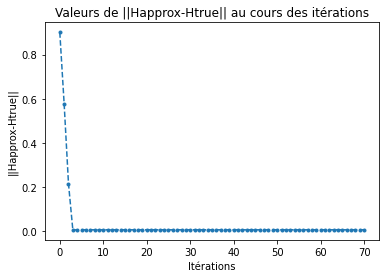

In [36]:
# Comme I est bien symétrique et définie positive, l'algorithme devrait converger

# Pour le test 

f = lambda x,y : ( x - 1)**2 + 2*(y - 1)**2
df = lambda x,y : np.array([2*(x - 1) , 4*(y - 1)])
#ddf = lambda x,y : np.array([[2  , 0], [0, 2]])
HH = lambda x,y : np.array([[.5, 0], [0, .25]])

## Paramètres
c, beta = .1, .75
epsilon = 1e-8
nmax = 200
iter_ls_max = 40
x0 = np.array([0., 0.])
H0 = np.eye(2)
np.set_printoptions(precision=3)
np.set_printoptions(suppress="True")

# Fonction BFGS 
def bfgs_optimization(f, df, HH, x0, H0, c, beta, epsilon, nmax):
    x = x0
    H_app = H0
    x_list = [x]
    H_diff_list = [np.linalg.norm(H_app - HH(x[0], x[1]))]
    alpha_list = []  # Liste pour stocker les valeurs de alpha

    alpha = 1
    d = -np.dot(H_app, df(x[0], x[1]))
    i = 0

    while i < nmax and np.linalg.norm(d) > epsilon:
        if i > 0:
            alpha = alpha / beta
        while f(x[0] + alpha*d[0], x[1] + alpha*d[1]) > f(x[0], x[1]) - c * alpha * (np.linalg.norm(d)**2):
            alpha *= beta
        alpha_list.append(alpha)
        x = x + alpha * d
        x_list.append(x)
        a = df(x[0], x[1]) - df(x_list[i][0], x_list[i][1])
        b = x - x_list[i]
        rho = 1 / np.dot(a, b)
        H_app = (np.eye(len(x)) - rho * np.outer(b, a)).dot(H_app).dot(np.eye(len(x)) - rho * np.outer(a, b)) + rho * np.outer(b, b)
        alpha /= beta
        d = -np.dot(H_app, df(x[0], x[1]))
        H_diff_list.append(np.linalg.norm(H_app - HH(x[0], x[1])))
        i += 1

    return x_list, H_diff_list, alpha_list, i 

x_list, H_diff_list,alpha_list, iterations = bfgs_optimization(f, df, HH, x0, H0, c, beta, epsilon, nmax)
print('Minimum de f = ', f(x_list[-1][0], x_list[-1][1]), ' atteint en x = ', x_list[-1], ' avec un nombre d\'itérations =', iterations)

# Représentation graphique de la trajectoire d'optimisation
def plot_trajectoire_BFGS(x_list):
    plt.figure()
    plt.plot([x[0] for x in x_list], [x[1] for x in x_list], '.', linestyle='-')
    level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
    draw_vector_field(df, 0, 2, 0, 2, 10)
    plt.axis('equal')
    plt.title("Trajectoire d'optimisation BFGS")
    plt.show()

# Représentation graphique des valeurs de f au cours des itérations.
def plot_f(x_list):
    plt.figure()
    plt.semilogy(range(len(x_list)), [f(x[0],x[1]) for x in x_list], '.', linestyle='dashed')
    plt.title('Valeurs de log(f) au cours des itérations')
    plt.xlabel('Itérations')
    plt.ylabel('log(f)')
    plt.show()

# Représentation graphique des valeurs de ||Happrox-Htrue|| au cours des itérations
def plot_H_conv(H_diff_list):
    plt.figure()
    plt.plot(range(len(H_diff_list)), H_diff_list, '.', linestyle='dashed')
    plt.title('Valeurs de ||Happrox-Htrue|| au cours des itérations')
    plt.xlabel('Itérations')
    plt.ylabel('||Happrox-Htrue||')
    plt.show()

# Affichage graphique

plot_f(x_list)
plot_trajectoire_BFGS(x_list)
plot_H_conv(H_diff_list)

> On remarque une convergence rapide de x vers le minimum (1,1). Le log(f) semble décroitre linéairement et rapidement, indiquant une convergence efficace vers le minimum de la fonction.
> 
> Le dernier graphique représente l'écart entre l'approximation de la Hessienne utilisée dans l'algorithme BFGS et la Hessienne théorique. L'écart diminue drastiquement dès les premières itérations, ne nécessitant que 3 ou 4 pas, ce qui suggère que l'approximation devient de plus en plus précise.
>
> Nous allons appliquer cette méthode à notre fonction avec le paramètre lambda.

Minimum de f =  2.45603332465884e-18  atteint en x =  [1. 1.]  avec un nombre d'itérations = 32


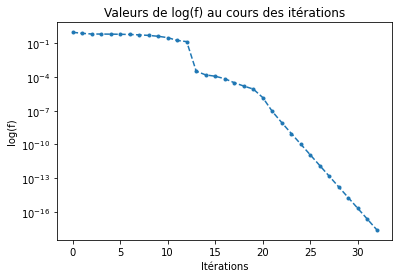

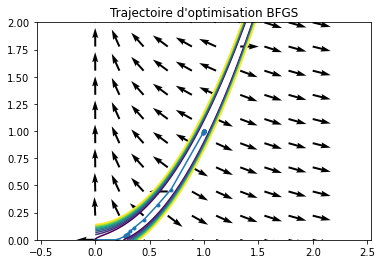

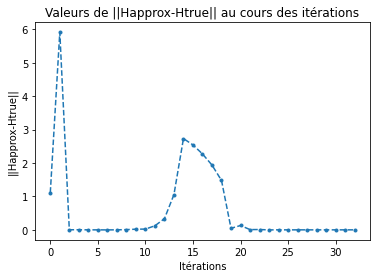

In [37]:
## Solution
Lambda = 100
f = lambda x,y : ( x - 1)**2 + Lambda*(y - x**2)**2
df = lambda x,y : np.array([2*(x - 1) + 4*Lambda*x*(x**2 - y), 2*Lambda*(y - x**2)])
ddf = lambda x,y : np.array([[2 - 4*Lambda*y + 12*Lambda*x**2 , 
                              -4*Lambda*x],[-4*Lambda*x, 2*Lambda]])
HH = lambda x,y : (1/(4*Lambda - 8*(Lambda**2)*y 
                    + 8*(Lambda**2)*x**2))*np.array([[2*Lambda, 4*Lambda*x],
                    [4*Lambda*x, 2 - 4*Lambda*y + 12*Lambda*x**2 ]])

## Paramètres
c, beta = .1, .75
epsilon = 1e-8
nmax = 200
iter_ls_max = 50

x_list, H_diff_list,alpha_list, iterations= bfgs_optimization(f, df, HH, x0, H0, c, beta, epsilon, nmax)
print('Minimum de f = ', f(x_list[-1][0], x_list[-1][1]), ' atteint en x = ', x_list[-1], ' avec un nombre d\'itérations =', iterations)

# Affichage graphique
plot_f(x_list)
plot_trajectoire_BFGS(x_list)
plot_H_conv(H_diff_list)

__Question 20.__ Est-ce que $H^k$ converge vers $[D^2 f(x^*)]^{-1}$ ?

> On observe à nouveau le comportement caractéristique d'une méthode de Newton, à savoir une convergence lente puis une convergence rapide de manière successive. Néanmoins, la méthode BFGS nécessite plus d'itérations que la méthode de Newton pour converger ( 32 itérations pour BFGS contre 20 pour Newton), mais nous évite de résoudre des systèmes linéaires coûteux en grande dimension.
>
> Pour ce qui est de la convergence de $H^k$ vers $[D^2 f(x^*)]^{-1}$, on remarque une "pseudo-convergence" malgrè qu'il y ai un rebond lors de la 15e itération. $H^k$ tends à être davantage une approximation de $[D^2 f(x^*)]^{-1}$.